**ConvNet классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

---

LeCun Y., Boser B., Denker J.S., Henderson D., Howard R.E., Hubbard W., Jackel L.D.    
Backpropagation applied to handwritten zip code recognition.   
Neural Computation 1989 1(4):541-551.   
http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf

Е.С.Борисов Классификатор изображений на основе свёрточной сети.  
http://mechanoid.su/ml-lenet.html

Е.С.Борисов  О методах обучения многослойных нейронных сетей прямого распространения.    
http://mechanoid.su/neural-net-backprop.html  
http://mechanoid.su/neural-net-backprop2.html

---

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

---

In [2]:
from sklearn.datasets import load_digits
data = load_digits()

display( data.keys() )
# print(data['DESCR'])

x = data['images'][:,:,:,np.newaxis]
target = data['target']

display( ( x.shape, target.shape ) )

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

((1797, 8, 8, 1), (1797,))

In [3]:
# np.squeeze(x[0])#.shape

In [4]:
# x.mean()

In [5]:
# def MinMaxScaler(x): return (x-x.min())/(x.max()-x.min())
# x = MinMaxScaler(x)
# x = (x>5).astype(np.uint8)

In [6]:
m = 64
ii = rng.permutation(len(x))[:m]
fig,ax = plt.subplots(1,len(ii),figsize=(11,1))
for i in range(len(ii)):
    ax[i].imshow(x[ii[i]],cmap='binary')
    ax[i].axis('off')

---

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, target_train, target_test = train_test_split(x,target,test_size=.5)
display( x_train.shape, x_test.shape, )

assert len(target_train) == len(x_train)
assert len(target_test) == len(x_test)

(898, 8, 8, 1)

(899, 8, 8, 1)

In [8]:
n_classes = len(set(target))
y_train = np.eye(n_classes)[target_train]
y_test  = np.eye(n_classes)[target_test]

display(n_classes, y_train.shape, y_test.shape)

10

(898, 10)

(899, 10)

In [9]:
del x,target

# строим модель

схема нейрона

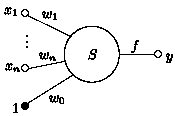

## модель слоя сети

In [10]:
class Model:
    
    def forward(self,x): pass

    def forward_train(self,x): pass
    
    def backward(self,d): pass
    
    def gradient(self,x,d): pass
    
    def __call__(self,x):
        return self.forward(x)
        
    def predict(self,x):
        return np.argmax(self.forward(x),axis=-1)
    
    @property
    def weight(self): pass

    @weight.setter
    def weight(self,w): pass

## линейный слой

In [11]:
class Linear(Model):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self._weight = rng.normal(loc=0.,scale=1e-1,size=(in_size,out_size))
        self._bias = np.zeros(shape=(1,out_size))
        
    def forward(self,x):
        assert len(x)>0
        assert x.shape[-1]==self._weight.shape[0]
        return x.dot(self._weight)+self._bias

    def forward_train(self,x):
        return self.forward(x)
    
    def backward(self,d):
        return d.dot(self._weight.T)
    
    def gradient(self,x,d):
        return x.T.dot(d), d.sum(axis=0,keepdims=True) 
    
    @property
    def weight(self):
        return self._weight, self._bias

    @weight.setter
    def weight(self,w):
        self._weight=w[0] 
        self._bias=w[1]
        return self

In [12]:
# display((x_train.shape,y_train.shape))

# model = Linear(in_size=x_train.shape[1],out_size=y_train.shape[1])

# o = model(x_train)
# display(o.shape)

# o = model.forward_train(x_train)
# display(o.shape)

# d = model.backward(y_train-o)
# display(d.shape)

# dw,db = model.gradient(x_train,d)
# display((dw.shape,db.shape))

## свёрточный слой

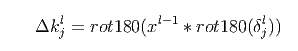

In [13]:
from scipy.signal import convolve2d

class Conv2d(Model):
    
    def __init__(self,kernel_size,kernel_count):
        super().__init__()
        self._kernels = rng.normal(loc=0.,scale=1e-2,size=(kernel_count,*kernel_size))
        self._bias = np.zeros(kernel_count)
        
    def forward(self,x):
        assert len(x)>0
        return np.stack([ 
                self.conv2d( x.sum(axis=-1), self._kernels[i], mode='valid') 
                for i in range(len(self._kernels)) 
            ],axis=-1) - self._bias

    def forward_train(self,x):
        return self.forward(x)
        
    def backward(self,d):
        return np.stack([ 
                self.conv2d( d.sum(axis=-1), self._kernels[i].swapaxes(0,1), mode='full' ) 
                for i in range(len(self._kernels)) 
            ],axis=-1)

    def gradient(self,x,d):
        assert len(x)==len(d)
        x_ = x.sum(axis=-1)
        dk = np.stack([
                [ 
                    convolve2d( x_[i], d[i,:,:,j].swapaxes(0,1), mode='valid' ).swapaxes(0,1)
                    for i in range(x_.shape[0]) 
                ] for j in range(d.shape[-1])
            ]).mean(axis=1)
        db = d.sum(axis=1).sum(axis=1).mean(axis=0)
        return dk,db
                
    @property
    def weight(self):
        return self._kernels, self._bias

    @weight.setter
    def weight(self,w):
        self._kernels=w[0] 
        self._bias=w[1]
        return self
    
    @staticmethod
    def conv2d(x,k,mode='full'): 
        n,h,w = x.shape # размеры карты
        s = (k.shape[0]//2)  # увеличение края при свёртке схемой full
        z = np.zeros((n,s,w)) # разделительные полосы
        x = np.hstack([z,x,z]) # вставляем разделительные полосы
        x = x.reshape(n*h+n*s*2,w) # преобразование в 2D
        x = convolve2d(x,k,mode='full') # выполняем свёртку 2D
        x = x[s:-s,:] # обрезаем лишнее 
        x = x.reshape(n,h+s*2,w+s*2) # обратное преобразование размерности
        return {
                'full': x,
                'same': x[:,s:-s,s:-s],
               'valid': x[:,s*2:-s*2,s*2:-s*2],
            }[mode]

In [14]:
# display((x_train.shape,y_train.shape))

# model = Conv2d(kernel_size=(3,3),kernel_count=5)

# o = model(x_train)
# display(o.shape)

# o = model.forward_train(x_train)
# display(o.shape)

# d = model.backward(o)
# display(d.shape)

# dk,db = model.gradient(x_train,o)
# display(dk.shape,db.shape)

## функция активации

In [15]:
class Activation:
    
    def forward(self,x): pass

    def backward(self,x): pass # производная активации
    
    def __call__(self,x):
        return self.forward(x)    

In [16]:
class BiSigmoid(Activation):
    
    def forward(self,x): 
        return np.tanh(x)

    def backward(self,x): # производная активации
        return 1./(np.cosh(x)**2)

Text(0.5, 1.0, 'd bi_sigmoid')

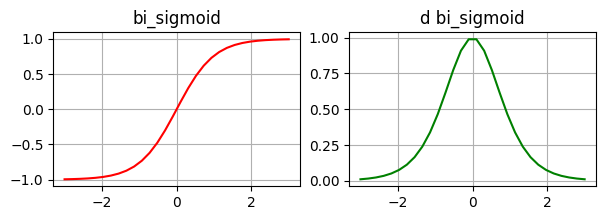

In [17]:
f = BiSigmoid()
x = np.linspace(-3,3,30)
fig,ax = plt.subplots(ncols=2,figsize=(7,2))
ax[0].plot(x,f(x),'-r')
ax[0].grid()
ax[0].set_title('bi_sigmoid' )
ax[1].plot(x,f.backward(x),'-g')
ax[1].grid()
ax[1].set_title('d bi_sigmoid' )

$$
sigmoid(x) = \frac{1}{1+\exp(-x)}
$$

In [18]:
class Sigmoid(Activation): # функция активации
    
    def forward(self,x): 
        return 1./(1. + np.exp(-x))

    def backward(self,x): # производная активации
        return np.square(self.forward(x))*np.exp(-x) 

Text(0.5, 1.0, 'd sigmoid')

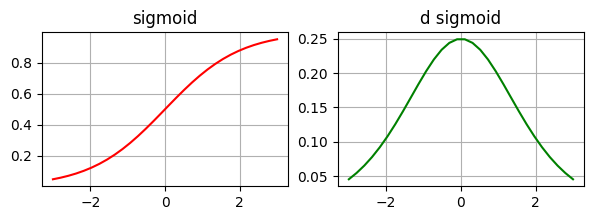

In [19]:
f = Sigmoid()
x = np.linspace(-3,3,30)
fig,ax = plt.subplots(ncols=2,figsize=(7,2))
ax[0].plot(x,f(x),'-r')
ax[0].grid()
ax[0].set_title('sigmoid' )
ax[1].plot(x,f.backward(x),'-g')
ax[1].grid()
ax[1].set_title('d sigmoid' )

$$
softmax(x) = \frac{\exp(x)}{\sum{\exp(x)}}
$$

In [20]:
class Softmax(Activation):
    
    def forward(self,x): 
        e = np.exp(x)
        return e/e.sum(axis=-1,keepdims=True)

    def backward(self,x): 
        o = self.forward(x)
        return o*(1.-o)

## ConvNet

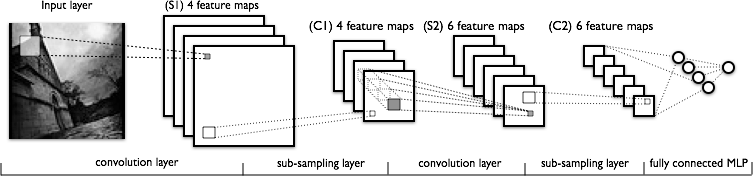

схема MPL 

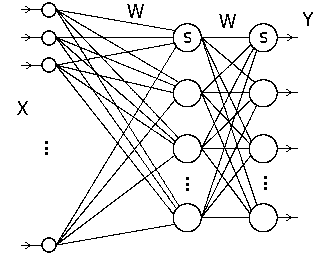

градиент функции потери - частные производные по всем параметрам модели, направление наискорейшего возрастания функции 

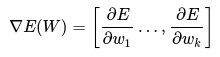


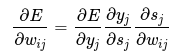

процедура обратного распространения ошибки

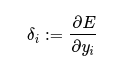

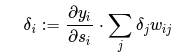

In [21]:
class ConvNet(Model):
    
    def __init__(self,kernel_size,kernel_count,hidden_size,out_size):
        super().__init__()
        self._act0 = BiSigmoid()
        self._act1 = Softmax()
        self._conv0 =  Conv2d(kernel_size=kernel_size,kernel_count=kernel_count)
        self._lin1 = Linear(hidden_size,out_size)
                
    @property
    def weight(self):
        return self._conv0.weight, self._lin1.weight

    @weight.setter
    def weight(self,w):
        self._conv0.weight=w[0] 
        self._lin1.weight=w[1]
        return self
    
    def forward(self,x):
        assert len(x)>0
        o = self._conv0(x)
        o = self._act0(o)
        n,h,w,c = o.shape
        o = o.reshape(n,h*w*c)
        o = self._lin1(o)
        o = self._act1(o)
        return o
    
    def forward_train(self,x):
        state,out = [x],[x]
        
        s = self._conv0.forward_train(out[-1])
        state.append(s)
        o = self._act0(s)
        out.append(o)
        
        n,h,w,c = s.shape
        s = s.reshape(n,h*w*c)
        state.append(s)
        o = o.reshape(n,h*w*c)
        out.append(o)
        
        s = self._lin1.forward_train(o)
        state.append(s)
        o = self._act1(s)
        out.append(o)
        
        return state, out
    
    def backward(self,d,state):
        delta = [ d*self._act1.backward(state[-1]) ]
        delta.append( self._lin1.backward( delta[-1]  ) * self._act0.backward( state[-2]) )
        n,h,w,c = state[-3].shape
        delta.append( delta[-1].reshape(n,h,w,c) )
        return delta[::-1] 
    
    def gradient(self,out,delta):
        dk0,db0 = self._conv0.gradient(out[0],delta[0])    
        dw1,db1 = self._lin1.gradient(out[2],delta[2])    
        return [dk0,db0],[dw1,db1]

In [22]:
# n,h,w,c = x_train.shape
# kernel_size=(3,3)
# kernel_count=5

# sw,sh = kernel_size[1]//2, kernel_size[0]//2

# hidden_size = kernel_count*(h-sh*2)*(w-sw*2)

# model = ConvNet(
#         kernel_size=kernel_size,
#         kernel_count=kernel_count,
#         hidden_size=hidden_size,
#         out_size=y_train.shape[1]
#     )

# o = model(x_train)
# display(o.shape)

# s,o = model.forward_train(x_train)
# display( len(s), len(o))

# d = model.backward(o[-1],s)
# display( len(d) )

# g = model.gradient(o,d)
# display( len(g) )

# обучаем модель

In [23]:
class Loss:
    
    def __init__(self,model): 
        self._model = model
        self._history = []
                
    def estimate(self,x,target):
        s = self._estimate( predicted=self._model(x), target=target, )
        self._history.append(s)
        return s
        
    def _estimate(self,predicted,target): pass
    
    def gradient(self,x,target):
        s,o = model.forward_train(x) # состояния и выходы всех нейронов сети
        d0 = self._gradient(o=o[-1],target=target) # ошибка выходного слоя
        d = model.backward(d0,s) # значение ошибки для всех нейронов скрытых слоёв
        return model.gradient(o,d) 
    
    def _gradient(self,o,target): pass
    
    def __call__(self,x,target):
        return self.estimate(x,target)        
    
    @property
    def model(self): 
        return self._model

функция потери - кросс-энтропия

$$L = CE(y,o) = -y\cdot log(o) - (1-y) \cdot log(1-o)  $$

$$  \nabla L = \frac{\partial L}{\partial w} = -\frac{o-y }{o (o-1)}\cdot \frac{\partial o}{\partial w}$$ 

In [24]:
class CELoss(Loss):
    
    def _estimate(self,predicted,target):
        o,y=predicted,target
        with np.errstate(divide='ignore',invalid='ignore'):
            # доопределяем нулями логарифм для аргументов меньше или равно 0
            l0 = np.where( o<1., (1-y)*np.log(1.-o), 0. )
            l1 = np.where( o>0., y*np.log(o),        0. ) 
        return (-(l1+l0)).mean()    
    
    def _gradient(self,o,target):
        d = o*(o-1)
        with np.errstate(divide='ignore',invalid='ignore'):
            d = np.where(d!=0.,(1./d), .0 )
        return -(o-target)*d # ошибка выходного слоя

In [25]:
# n,h,w,c = x_train.shape
# kernel_size=(3,3)
# kernel_count=5

# sw,sh = kernel_size[1]//2, kernel_size[0]//2

# hidden_size = kernel_count*(h-sh*2)*(w-sw*2)

# model = ConvNet(
#         kernel_size=kernel_size,
#         kernel_count=kernel_count,
#         hidden_size=hidden_size,
#         out_size=y_train.shape[1]
#     )

# # o = model(x_train)
# # display(o.shape)

# loss = CELoss(model)

# er = loss.estimate(x_train,y_train)
# display( er )

# [dk0,db0],[dw1,db1] = loss.gradient(x_train,y_train)
# display((dk0.shape,db0.shape),(dw1.shape,db1.shape))

# обучаем

In [26]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

In [27]:
from copy import deepcopy

class Weight:
    
    def __init__(self,w):
        self._w = deepcopy(w)
    
    def __add__(self,w):
        return self._for_all(w,operation=lambda x,y:x+y)
        
    def __sub__(self,w):
        return self._for_all(w,operation=lambda x,y:x-y)
    
    def __mul__(self,w):  
        return self._for_all(w,operation=lambda x,y:x*y)
        
    def fill(self,w):
        return self._for_all(w,operation=lambda x,y: w )
        
    def _for_all(self,w,operation):  
        return Weight([ 
                [ 
                 operation( self._w[l][n], self._get_value(w,l,n) ) 
                 for n in range(len( self._w[l])) 
                ] # для каждого параметра слоя
                for l in range(len( self._w)) # для каждого слоя
            ])  
    
    def max(self):  
        return max([ 
                max([ np.abs(self._w[l][n]).max() 
                     for n in range(len( self._w[l])) 
                    ]) # для каждого параметра слоя
                for l in range(len( self._w)) # для каждого слоя
            ])
    
    
    def sum(self):  
        return sum([ 
                   sum([ np.abs(self._w[l][n]).sum() 
                     for n in range(len( self._w[l])) 
                    ]) # для каждого параметра слоя
                for l in range(len( self._w)) # для каждого слоя
            ])
    
    def norm(self):
        m = self.max()
        return self.__mul__(1./m) if m>0. else Weight(self._w)
    
    def _get_value(self,w,l,n):
        return w[l,n] if type(w) is Weight else w
        
    def __getitem__(self,idx): 
        return self._w[idx[0]][idx[1]]
    
    @property
    def value(self): return self._w

In [28]:
# w0 = Weight(model.weight)
# w0.value, w0.max(), w0.norm()

# w1 = Weight(model.weight)
# w0+w1
# w0.fill(-1.)

In [29]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

изменение весов

$$\Delta w_t = \eta \cdot \nabla L $$

In [30]:
class TrainGD:
    
    def __init__(self,loss,lr=1e-2): 
        self._loss = loss
        self._lr = lr # скорость обучения
        
    def fit(self,x,t,n_epoch=128):
        loss_history = [ self._loss.estimate(x,t) ]
        acc_history = [ accuracy_score(np.argmax(t,axis=-1),self._loss.model.predict(x)) ]
        for _ in tqdm(range(n_epoch)):
            self._fit_epoch(x,t)
            loss_history.append( self._loss.estimate(x,t) )
            acc_history.append( accuracy_score(np.argmax(t,axis=-1),self._loss.model.predict(x)) )
            if acc_history[-1]>.99: break
        return (acc_history,loss_history),self._loss.model 
    
    def _fit_epoch(self,x,t):
        dw = self._loss.gradient(x,t)
        dw = Weight(dw).norm().value
        self._weight_adjust(dw)  
        return self
        
    def _weight_adjust(self,dw):
        dw = Weight( self._weight_delta(dw) )
        w = Weight( self._loss.model.weight ) 
        self._loss.model.weight = (w-dw).value
        return self
        
    def _weight_delta(self,dw): # вычисляем изменение всех весов модели
        return ( Weight(dw)*self._lr ).value
        

In [31]:
# model = MLP3(in_size=x_train.shape[1],hidden_size=[10,5],out_size=y_train.shape[1])
# (acc_history,loss_history), model = TrainGD(
#         loss=MSQELoss(model),
#         lr=1e-2,
#     ).fit( x_train,y_train, n_epoch=128, )

изменение весов

$$\Delta w_t = \eta \cdot ( \nabla L + \rho\cdot W_{t-1} ) + \mu\cdot \Delta w_{t-1}$$

In [32]:
class TrainSGD(TrainGD):
    
    def __init__(self,loss,lr=1e-2,mu=0.,rho=0.): 
        super().__init__(loss,lr)
        self._dw = 0. # изменение весов на предыдущем шаге
        self._mu = mu # коэфициент момента
        self._rho = rho # коэфициент регуляризации
        self._bs = 1.
        
    def fit(self,x,t,n_epoch=128,batch_size=8):
        self._bs = batch_size
        return super().fit(x,t,n_epoch)
            
    def _fit_epoch(self,x,t):
        self._dw = Weight(self._loss.model.weight).fill(0.).value
        for x_,t_ in self._get_batch(x,t):
            super()._fit_epoch(x_,t_)
        return self

    # генератор батчей
    def _get_batch(self,x,y): 
        n_samples = len(y) # количество учебных пар
        batch_count = np.ceil( n_samples/self._bs).astype(int) # количество батчей
        # перемешиваем учебный набор и режем его на батчи
        for idx in np.array_split(rng.permutation(n_samples), batch_count ):
            yield x[idx,:],y[idx,:]
            
    def _weight_delta(self,dw): # вычисляем изменение всех весов модели
        w = Weight(self._loss.model.weight)
        self._dw = ( 
                ( Weight(dw)+w*self._rho )*self._lr 
                + Weight(self._dw)*self._mu 
            ).value    
        return self._dw

-----

In [33]:
n,h,w,c = x_train.shape
kernel_size=(3,3)
kernel_count=5

sw,sh = kernel_size[1]//2, kernel_size[0]//2

hidden_size = kernel_count*(h-sh*2)*(w-sw*2)

model = ConvNet(
        kernel_size=kernel_size,
        kernel_count=kernel_count,
        hidden_size=hidden_size,
        out_size=y_train.shape[1]
    )

# o = model(x_train)
# display(o.shape)

  0%|          | 0/256 [00:00<?, ?it/s]

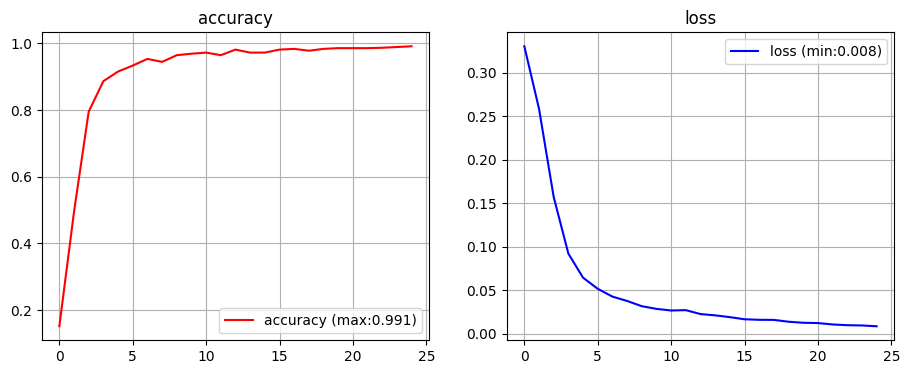

In [34]:
(acc_history,loss_history), model = TrainSGD(
        loss=CELoss(model), lr=1e-2, mu=1e-2, rho=1e-8,
    ).fit( x_train,y_train, n_epoch=256, batch_size=len(x_train)//16 )

# история изменения значений погрешности модели
fig,ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
ax[0].grid()
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax[1].grid()
ax[1].set_title('loss')
ax[1].legend()

# тестируем

In [35]:
from sklearn.metrics import classification_report

score = model.forward(x_test)
predicted = np.argmax(score,axis=-1)
#predicted = model.predict(x_test_)

print(classification_report( target_test, predicted) )

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.94      0.98      0.96        86
           2       0.94      0.97      0.95        86
           3       0.98      0.93      0.96        91
           4       0.96      1.00      0.98        91
           5       0.94      0.91      0.93        89
           6       0.98      0.92      0.95        99
           7       1.00      0.96      0.98        84
           8       0.84      0.90      0.87        84
           9       0.90      0.92      0.91        89

    accuracy                           0.95       899
   macro avg       0.95      0.95      0.95       899
weighted avg       0.95      0.95      0.95       899



In [134]:
# from sklearn.metrics import RocCurveDisplay

# ncols = 3
# n_classes = len(set(target_test))
# nrows = np.ceil(n_classes/ncols).astype(int)

# # история изменения значений погрешности модели
# fig,ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(11,nrows*4),sharey=True,sharex=True)
# for r in range(nrows):
#     for c in range(ncols):
#         l = r*ncols+c
#         if l+1>n_classes: 
#             ax[r,c].axis('off')
#             continue
#         t = (target_test==l).astype(np.uint8)
#         s = score[:,l]
#         RocCurveDisplay.from_predictions( t,s, name=f'class {c}', color='darkorange', ax=ax[r,c] )
#         ax[r,c].plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
#         ax[r,c].grid()